In [9]:
# loading required packages
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Flatten
from keras.metrics import Sum
import pandas as pd

# Oxford Pet Dataset- a ResNet/U-Net understanding

In [10]:
# importing oxford iii pet datasets
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [11]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\jkuhn\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [12]:
# extract an unseen dataset from test_dataset that will not be used in training
# we will take 10% of test dataset into an unseen dataset
dataset['unseen'] = dataset['test'].take(round(len(dataset['test'])*0.10))
dataset['test'] = dataset['test'].skip(round(len(dataset['test'])*0.10))
print('test random',len(dataset['test']))
print('unseen',len(dataset['unseen']))

test random 3302
unseen 367


In [13]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [14]:
train = dataset['train'].map(load_image_train)
unseen = dataset['unseen'].map(load_image_unseen)
test = dataset['test'].map(load_image_test)

In [15]:
BATCH_SIZE = 32

train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [16]:
def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()


def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

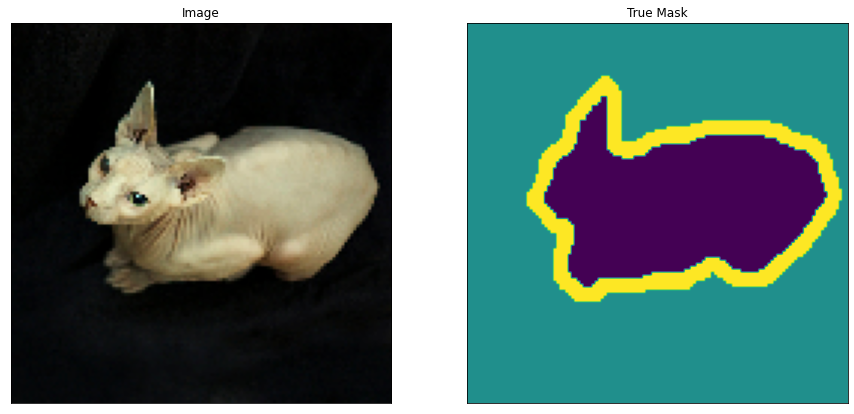

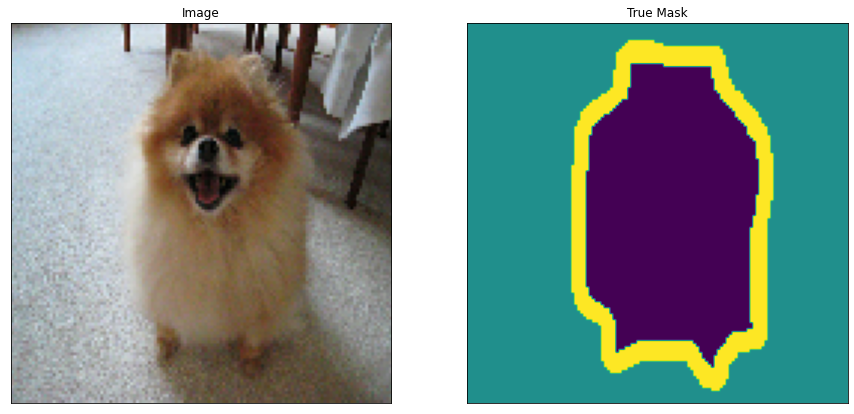

In [9]:
show_image_from_dataset(train)
show_image_from_dataset(test)

# First model with simple U-Net
based on https://medium.com/geekculture/semantic-image-segmentation-using-unet-28dbc247d63e

In [41]:
# UNet Encoder
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x
    
def encoder_block(inputs, n_filters = 64, pool_size = (2,2), dropout = 0.3):
    f = conv2d_block(inputs, n_filters = n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def encoder(inputs):
    f1,p1=encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2,p2=encoder_block(p1, n_filters=128, pool_size=(2,2), dropout = 0.3)
    f3,p3 = encoder_block(p2, n_filters = 256, pool_size=(2,2), dropout=0.3)
    f4,p4 = encoder_block(p3, n_filters = 512, pool_size=(2,2), dropout=0.3)
    return p4, (f1, f2, f3, f4)

# adding a bottleneck output
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters = 1024)
    return bottle_neck

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters = 64, kernel_size = 3,
                  strides = 3, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c7 = decoder_block(c6, f3, n_filters = 256, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c8 = decoder_block(c7, f2, n_filters = 128, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c9 = decoder_block(c8, f1, n_filters = 64, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation = 'softmax')(c9)
    return outputs

In [42]:
# creating the model

OUTPUT_CHANNELS = 3

def unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, output_channels = OUTPUT_CHANNELS)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_simpleunet = unet()
model_simpleunet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
____________________________________________________________________________________________

In [49]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'simpleUNet_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
model_simpleunet.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_simpleunet_history = model_simpleunet.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 1808s 16s/step - loss: 0.7863 - accuracy: 0.6536 - val_loss: 0.6620 - val_accuracy: 0.7392
Epoch 2/10
115/115 [==============================] - 1793s 16s/step - loss: 0.6013 - accuracy: 0.7614 - val_loss: 0.5754 - val_accuracy: 0.7759
Epoch 3/10
115/115 [==============================] - 1802s 16s/step - loss: 0.5222 - accuracy: 0.7963 - val_loss: 0.4714 - val_accuracy: 0.8160
Epoch 4/10
115/115 [==============================] - 1810s 16s/step - loss: 0.4735 - accuracy: 0.8171 - val_loss: 0.4425 - val_accuracy: 0.8311
Epoch 5/10
115/115 [==============================] - 1818s 16s/step - loss: 0.4364 - accuracy: 0.8317 - val_loss: 0.4111 - val_accuracy: 0.8416
Epoch 6/10
115/115 [==============================] - 1798s 16s/step - loss: 0.4054 - accuracy: 0.8445 - val_loss: 0.3936 - val_accuracy: 0.8489
Epoch 7/10
115/115 [==============================] - 1799s 16s/step - loss: 0.4018 - accuracy: 0.8462 - val_loss: 0.3997 - val_ac

In [50]:
model_simpleunet.save('simple_unet_test2.h5')

In [43]:
import keras
model_simpleunet = keras.models.load_model('simple_unet_test2.h5')

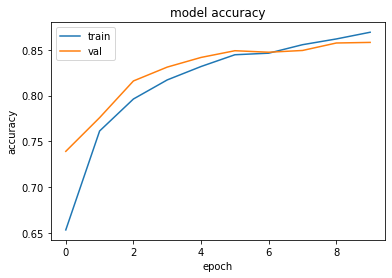

In [53]:
plt.plot(model_simpleunet_history.history['accuracy'])
plt.plot(model_simpleunet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

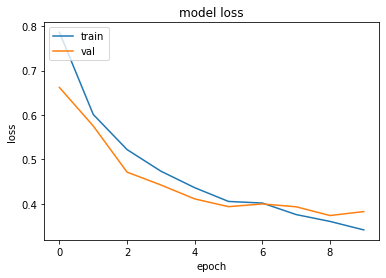

In [54]:
plt.plot(model_simpleunet_history.history['loss'])
plt.plot(model_simpleunet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
integer_slider = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_simpleunet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

def get_image_and_annotation_arrays(dataset):
  ds = dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def iou_score(target, pred):  
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [10]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_simpleunet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.8889112433125914
test IoU:  0.87339447420552
unseen IoU:  0.8773770072394537


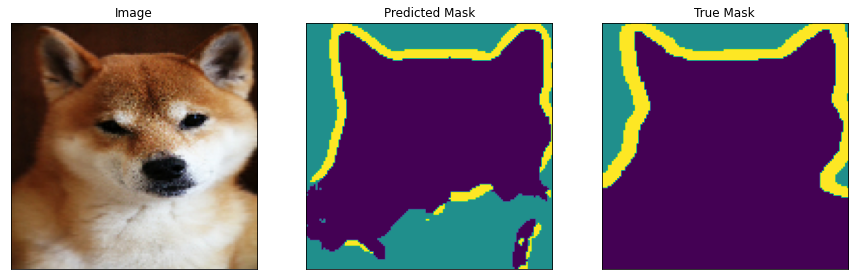

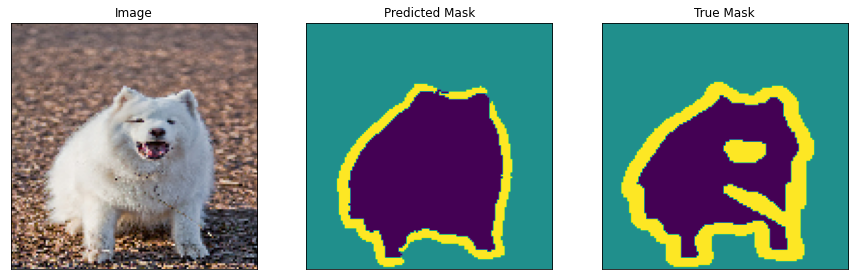

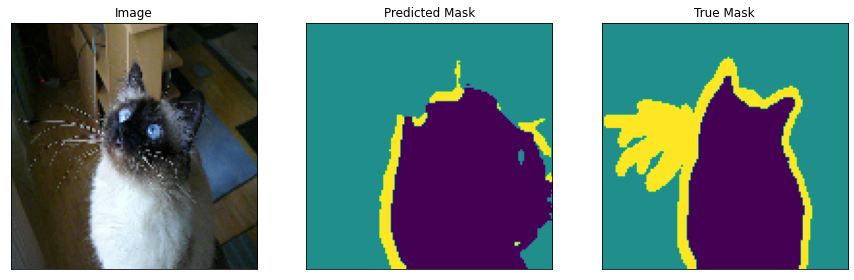

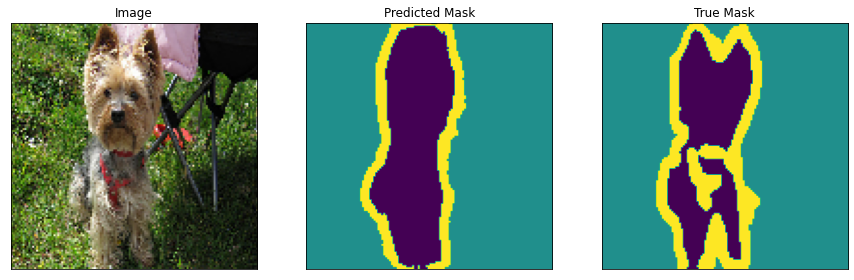

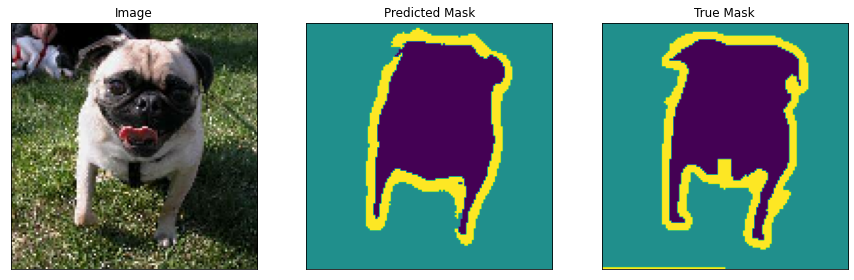

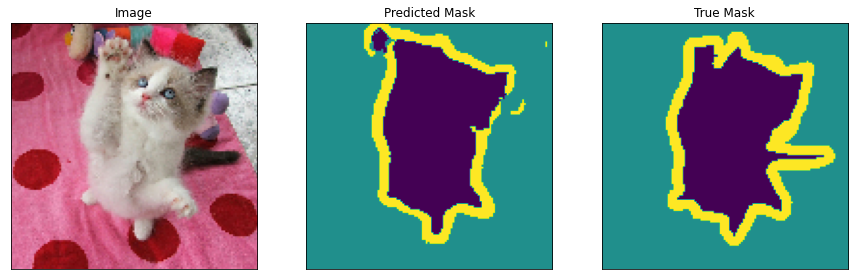

In [40]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


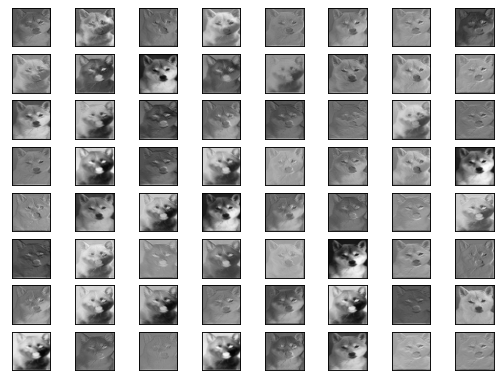

In [118]:
#feature_maps = model.predict(img)
#from keras.preprocessing.image import preprocess_input
from numpy import expand_dims

model = model_simpleunet
# redefine to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

img = unseen_image[15]
img = expand_dims(img, axis=0)
#img = preprocess_input(img)

feature_maps = model.predict(img)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1

plt.figure(figsize=(8, 6), dpi=80)
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :,ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [158]:
for layer in model_simpleunet.layers:
    print(layer.name)

input_3
conv2d_38
activation_36
conv2d_39
activation_37
max_pooling2d_8
dropout_16
conv2d_40
activation_38
conv2d_41
activation_39
max_pooling2d_9
dropout_17
conv2d_42
activation_40
conv2d_43
activation_41
max_pooling2d_10
dropout_18
conv2d_44
activation_42
conv2d_45
activation_43
max_pooling2d_11
dropout_19
conv2d_46
activation_44
conv2d_47
activation_45
conv2d_transpose_8
concatenate_8
dropout_20
conv2d_48
activation_46
conv2d_49
activation_47
conv2d_transpose_9
concatenate_9
dropout_21
conv2d_50
activation_48
conv2d_51
activation_49
conv2d_transpose_10
concatenate_10
dropout_22
conv2d_52
activation_50
conv2d_53
activation_51
conv2d_transpose_11
concatenate_11
dropout_23
conv2d_54
activation_52
conv2d_55
activation_53
conv2d_56


In [152]:
model_simpleunet.layers.name

AttributeError: 'list' object has no attribute 'name'

In [163]:
from keras import backend as K
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model_simpleunet.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [164]:
plt.imshow(generate_pattern('conv2d_40',0))

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

# ResNet-50/U-NET

In [10]:
from keras.applications.resnet import ResNet50

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet50.ResNet50(include_top = False,
                                               input_tensor = x,
                                                weights = None,
                                               input_shape = (128, 128, 3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters, kernel_size,
                  strides=1, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, 
                                        strides = strides, 
                                        padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def resnet_decoder_block(inputs, output_channels, model_name):
    conv_layers = []
    for layer in model_name.layers:
        name_layers = layer.name
        if name_layers.endswith('conv'):
            conv_layers.append(name_layers)  # get conv layer name from CNNs
            
    model_inputs = []
    for name in conv_layers:
        a = model_name.get_layer(name).output
        model_inputs.append(a)   # get conv layer info from CNNs
        
    model_names = []   # get the outputs of each CNN blocks
    for m in range(len(model_inputs)):
        if model_inputs[m-1].shape[1] == model_inputs[m].shape[1]:
            continue
        model_names.append(model_inputs[m-1])
    model_names = model_names[1:] + model_names[:1]
    model_names = model_names[::-1] # get the inverse for the reverse
    
    for conv in model_names[1:-1]: #[:-1]:
        inputs = decoder_block(inputs, conv, n_filters = conv.shape[3], 
                               kernel_size = (3,3), 
                              strides = (2,2),
                              dropout = 0.3)
        
    inputs = decoder_block(inputs, model_names[-1], 
                           n_filters = model_names[-1].shape[3],
                          kernel_size = (3,3), strides = (2,2), dropout=0.3)
    
    # transpose result back to (128, 128) image
    inputs = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3),
                                            strides = (2,2), 
                                            kernel_initializer = 'he_normal',
                                            padding = 'same')(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = (tf.keras.layers.Conv2D(3, (1,1), activation = 'softmax'))(inputs)

    return inputs

In [11]:
# creating the model

OUTPUT_CHANNELS = 3

def ResNet50_Unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, 
                                   output_channels = OUTPUT_CHANNELS,
                                  model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet50 = ResNet50_Unet()
model_unet_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'model_unet_resnet_filepath_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnet50.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnet50_history = model_unet_resnet50.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 1711s 15s/step - loss: 0.7075 - accuracy: 0.6986 - val_loss: 1.2255 - val_accuracy: 0.3973


C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
115/115 [==============================] - 1686s 15s/step - loss: 0.5330 - accuracy: 0.7918 - val_loss: 1.2860 - val_accuracy: 0.4500
Epoch 3/10
115/115 [==============================] - 1628s 14s/step - loss: 0.4723 - accuracy: 0.8176 - val_loss: 0.6791 - val_accuracy: 0.7431
Epoch 4/10
115/115 [==============================] - 1633s 14s/step - loss: 0.4263 - accuracy: 0.8359 - val_loss: 0.5427 - val_accuracy: 0.7865
Epoch 5/10
115/115 [==============================] - 1585s 14s/step - loss: 0.4057 - accuracy: 0.8443 - val_loss: 0.9520 - val_accuracy: 0.6857
Epoch 6/10
115/115 [==============================] - 1605s 14s/step - loss: 0.3792 - accuracy: 0.8547 - val_loss: 0.5715 - val_accuracy: 0.7862
Epoch 7/10
115/115 [==============================] - 1676s 15s/step - loss: 0.3675 - accuracy: 0.8586 - val_loss: 1.2635 - val_accuracy: 0.6682
Epoch 8/10
115/115 [==============================] - 1656s 14s/step - loss: 0.3495 - accuracy: 0.8660 - val_loss: 0.7966 - val_ac

In [13]:
model_unet_resnet50.save('unet_resnet50_model.h5')

In [119]:
import keras
model_unet_resnet50 = keras.models.load_model('unet_resnet50_model.h5')

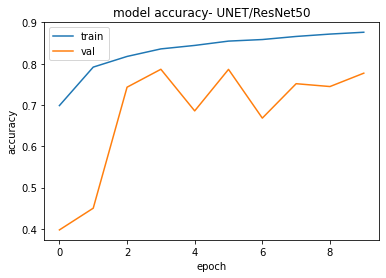

In [17]:
plt.plot(model_unet_resnet50_history.history['accuracy'])
plt.plot(model_unet_resnet50_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

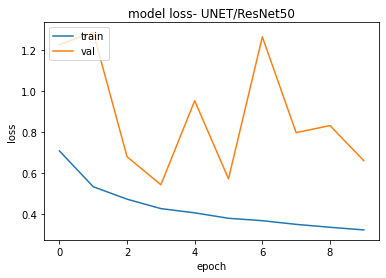

In [18]:
plt.plot(model_unet_resnet50_history.history['loss'])
plt.plot(model_unet_resnet50_history.history['val_loss'])
plt.title('model loss- UNET/ResNet50')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
integer_slider = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

def get_image_and_annotation_arrays(dataset):
  ds = dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def iou_score(target, pred):  
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [13]:
# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.8141041060832009
test IoU:  0.8082165502975392
unseen IoU:  0.8007282333041147


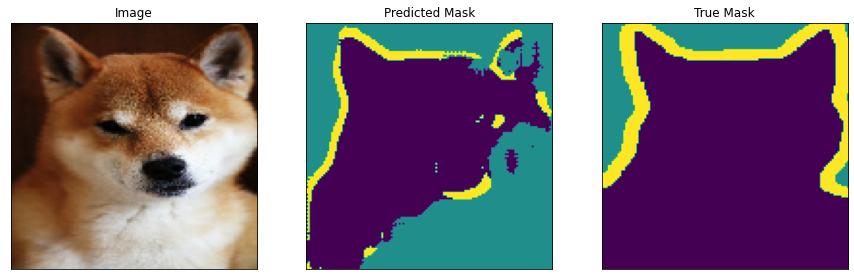

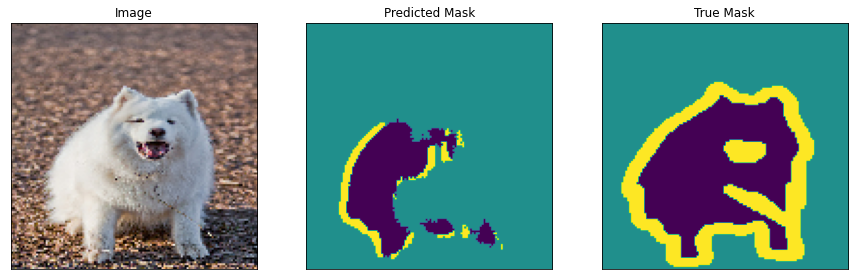

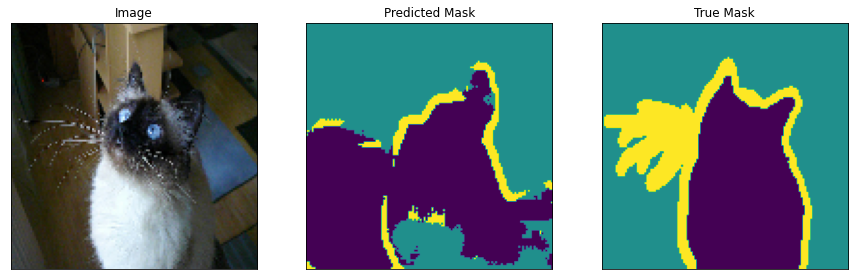

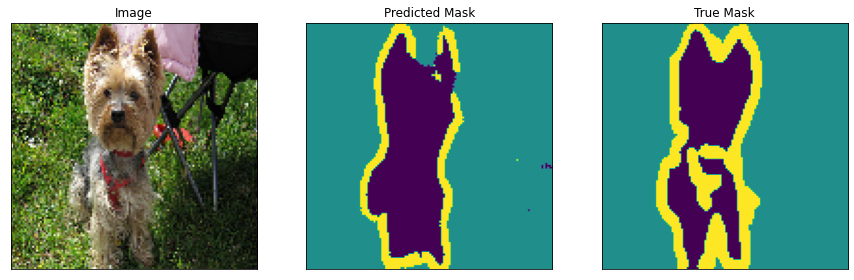

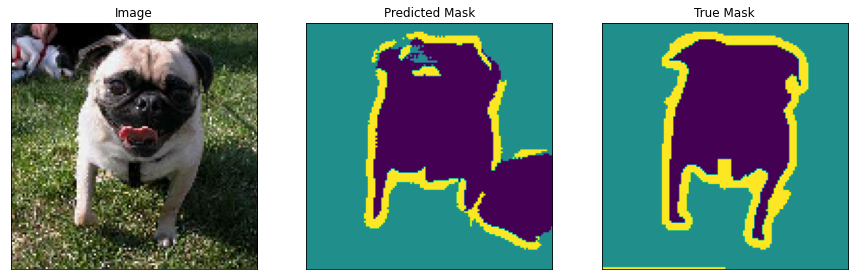

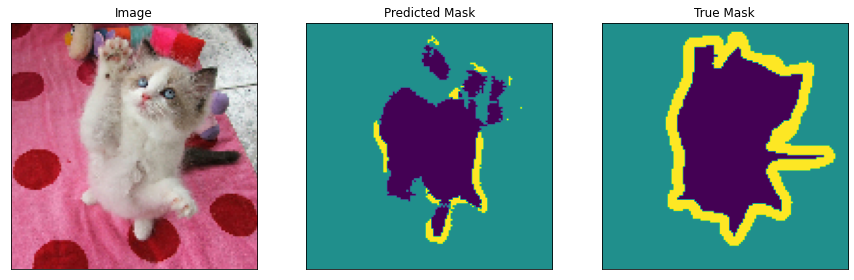

In [22]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


IndexError: index 3 is out of bounds for axis 3 with size 3

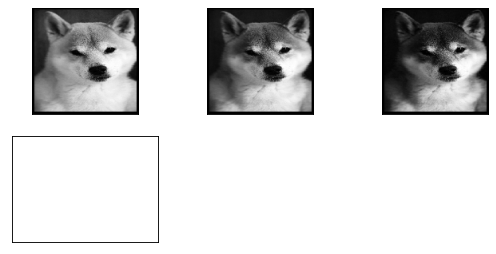

In [134]:
#feature_maps = model.predict(img)
#from keras.preprocessing.image import preprocess_input
from numpy import expand_dims

model = model_unet_resnet50
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

img = unseen_image[15]
img = expand_dims(img, axis=0)
#img = preprocess_input(img)

feature_maps = model.predict(img)

# plot all 64 maps in an 8x8 squares
square = 3
ix = 1

plt.figure(figsize=(8, 6), dpi=80)
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0,:, :,ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

# Adding data augmentation with simple U-Net

In [14]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def random_flip(input_image, input_mask):   # flips images and adds brightness differences
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [15]:
train = dataset['train'].map(load_image_train)
unseen = dataset['unseen'].map(load_image_unseen)
test = dataset['test'].map(load_image_test)

In [16]:
BATCH_SIZE = 32

train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [86]:
# UNet Encoder
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x
    
def encoder_block(inputs, n_filters = 64, pool_size = (2,2), dropout = 0.3):
    f = conv2d_block(inputs, n_filters = n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def encoder(inputs):
    f1,p1=encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2,p2=encoder_block(p1, n_filters=128, pool_size=(2,2), dropout = 0.3)
    f3,p3 = encoder_block(p2, n_filters = 256, pool_size=(2,2), dropout=0.3)
    f4,p4 = encoder_block(p3, n_filters = 512, pool_size=(2,2), dropout=0.3)
    return p4, (f1, f2, f3, f4)

# adding a bottleneck output
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters = 1024)
    return bottle_neck

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters = 64, kernel_size = 3,
                  strides = 3, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c7 = decoder_block(c6, f3, n_filters = 256, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c8 = decoder_block(c7, f2, n_filters = 128, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    c9 = decoder_block(c8, f1, n_filters = 64, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation = 'softmax')(c9)
    return outputs

In [87]:
# creating the model

OUTPUT_CHANNELS = 3

def unet_augmented():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, output_channels = OUTPUT_CHANNELS)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_simpleunet_augmented = unet_augmented()
model_simpleunet_augmented.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 128, 128, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 128, 128, 64) 0           conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 128, 128, 64) 36928       activation_81[0][0]              
____________________________________________________________________________________________

In [88]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'simpleUNet_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
model_simpleunet_augmented.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_simpleunet_augmented_history = model_simpleunet_augmented.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 2226s 19s/step - loss: 0.8227 - accuracy: 0.6392 - val_loss: 0.7027 - val_accuracy: 0.7056
Epoch 2/10
115/115 [==============================] - 1946s 17s/step - loss: 0.6485 - accuracy: 0.7355 - val_loss: 0.5895 - val_accuracy: 0.7639
Epoch 3/10
115/115 [==============================] - 1987s 17s/step - loss: 0.5679 - accuracy: 0.7751 - val_loss: 0.5203 - val_accuracy: 0.7948
Epoch 4/10
115/115 [==============================] - 1884s 16s/step - loss: 0.5086 - accuracy: 0.8012 - val_loss: 0.4673 - val_accuracy: 0.8150
Epoch 5/10
115/115 [==============================] - 1798s 16s/step - loss: 0.4664 - accuracy: 0.8195 - val_loss: 0.4299 - val_accuracy: 0.8358
Epoch 6/10
115/115 [==============================] - 1789s 16s/step - loss: 0.4322 - accuracy: 0.8339 - val_loss: 0.4128 - val_accuracy: 0.8425
Epoch 7/10
115/115 [==============================] - 1796s 16s/step - loss: 0.4113 - accuracy: 0.8427 - val_loss: 0.3878 - val_ac

In [17]:
#model_simpleunet_augmented.save('unet_augmented_model.h5')
model_simpleunet_augmented = keras.models.load_model('unet_augmented_model.h5')

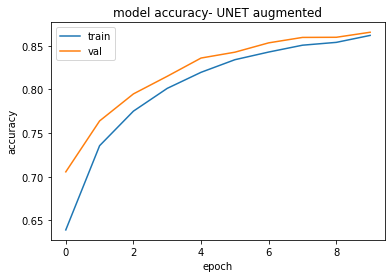

In [90]:
plt.plot(model_simpleunet_augmented_history.history['accuracy'])
plt.plot(model_simpleunet_augmented_history.history['val_accuracy'])
plt.title('model accuracy- UNET augmented')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

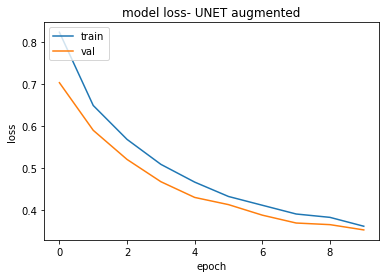

In [91]:
plt.plot(model_simpleunet_augmented_history.history['loss'])
plt.plot(model_simpleunet_augmented_history.history['val_loss'])
plt.title('model loss- UNET augmented')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_simpleunet_augmented.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.887806315663178
test IoU:  0.8811318296253099
unseen IoU:  0.8883053181825354


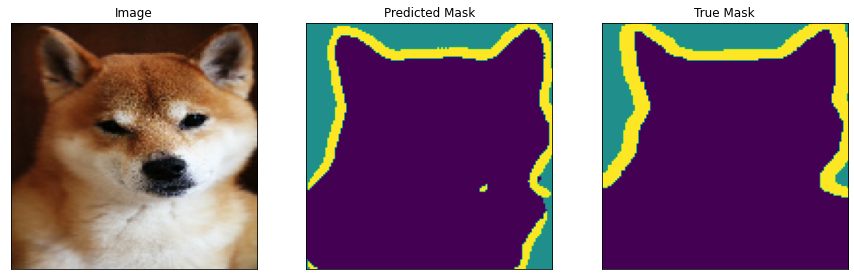

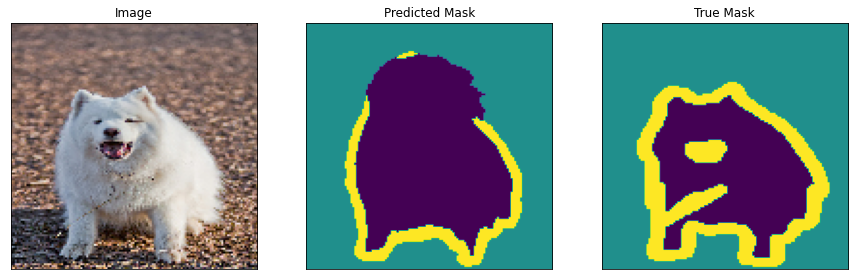

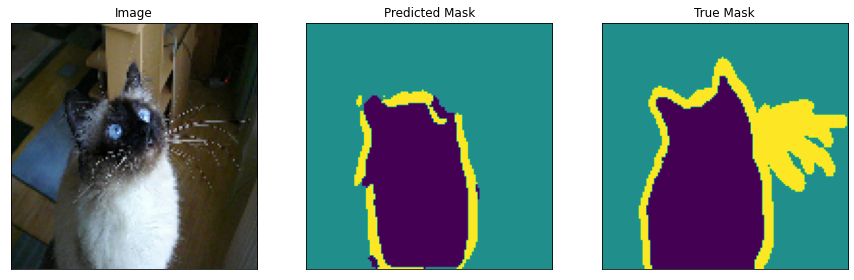

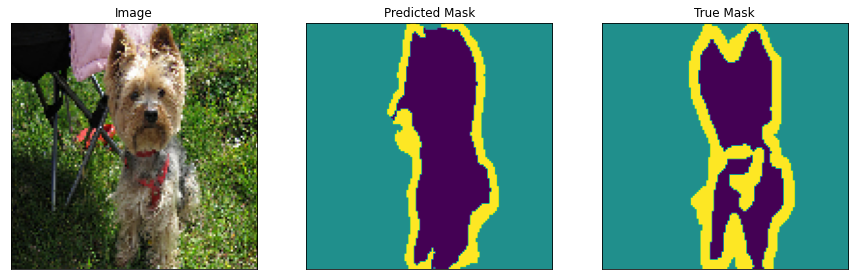

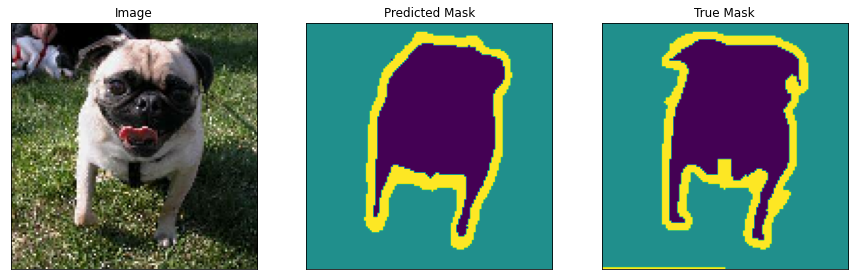

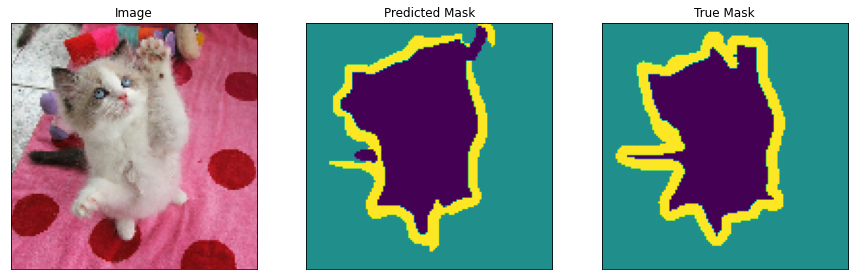

In [93]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

# ResNet50-UNET with augmented data

In [94]:
model_unet_resnet50_augmented = ResNet50_Unet()

In [95]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'model_unet_resnet_filepath_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnet50_augmented.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnet50_augmented_history = model_unet_resnet50_augmented.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 1604s 14s/step - loss: 0.7656 - accuracy: 0.6670 - val_loss: 0.8898 - val_accuracy: 0.6307
Epoch 2/10
115/115 [==============================] - 1611s 14s/step - loss: 0.5881 - accuracy: 0.7653 - val_loss: 1.0053 - val_accuracy: 0.5496
Epoch 3/10
115/115 [==============================] - 1612s 14s/step - loss: 0.5339 - accuracy: 0.7899 - val_loss: 0.8574 - val_accuracy: 0.6189
Epoch 4/10
115/115 [==============================] - 1606s 14s/step - loss: 0.4979 - accuracy: 0.8048 - val_loss: 0.5711 - val_accuracy: 0.7746
Epoch 5/10
115/115 [==============================] - 1612s 14s/step - loss: 0.4740 - accuracy: 0.8147 - val_loss: 0.6492 - val_accuracy: 0.7284
Epoch 6/10
115/115 [==============================] - 1613s 14s/step - loss: 0.4565 - accuracy: 0.8223 - val_loss: 0.9449 - val_accuracy: 0.6472
Epoch 7/10
115/115 [==============================] - 1619s 14s/step - loss: 0.4403 - accuracy: 0.8280 - val_loss: 1.1971 - val_ac

In [19]:
#model_unet_resnet50_augmented.save('unet_resnet50_augmented_model.h5')
model_unet_resnet50_augmented = keras.models.load_model('unet_resnet50_augmented_model.h5')

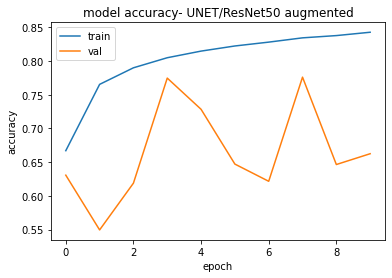

In [97]:
plt.plot(model_unet_resnet50_augmented_history.history['accuracy'])
plt.plot(model_unet_resnet50_augmented_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNet50 augmented')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

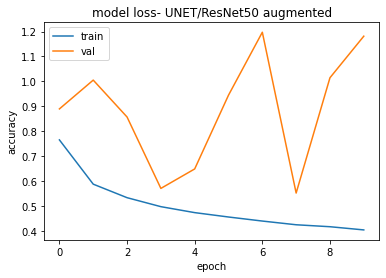

In [98]:
plt.plot(model_unet_resnet50_augmented_history.history['loss'])
plt.plot(model_unet_resnet50_augmented_history.history['val_loss'])
plt.title('model loss- UNET/ResNet50 augmented')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50_augmented.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.7468707560324116
test IoU:  0.7451578560498798
unseen IoU:  0.743143594563633


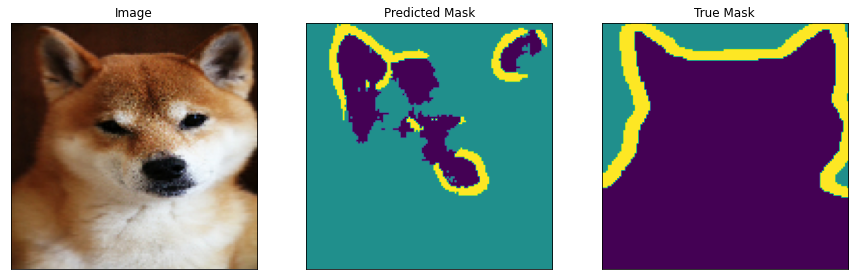

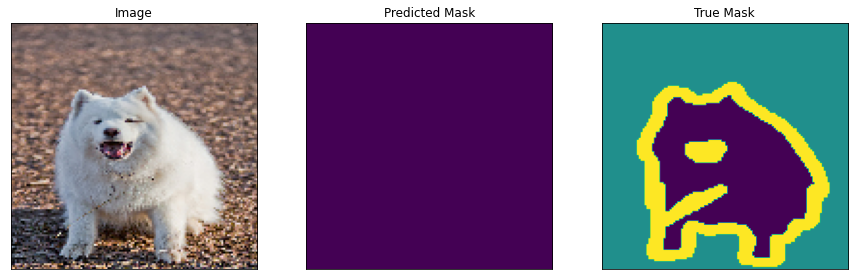

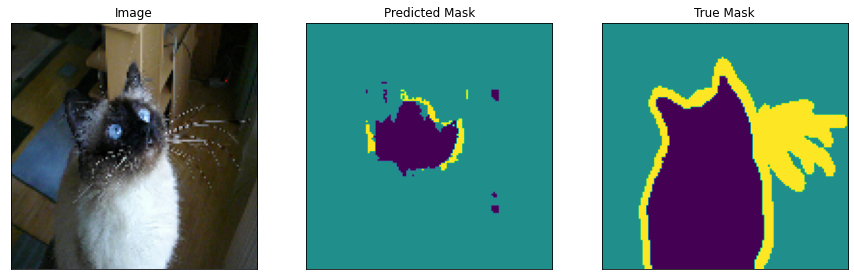

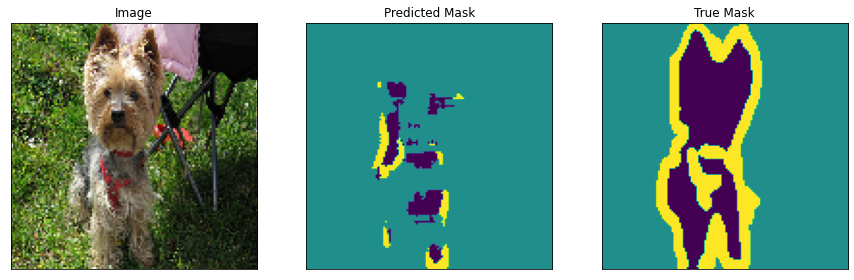

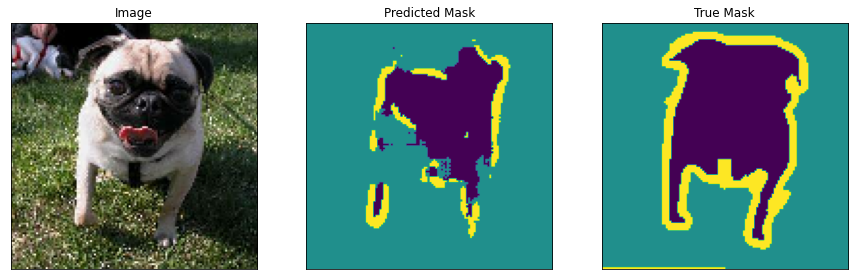

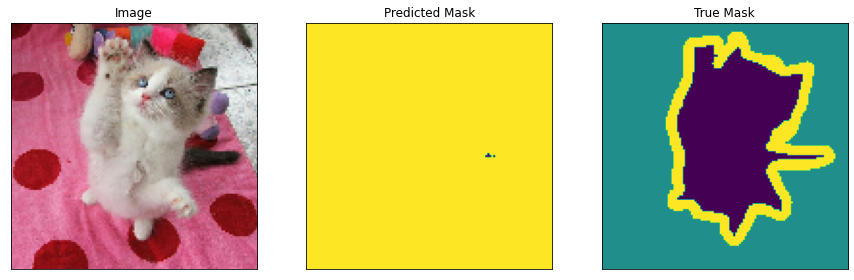

In [100]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

# ResNet50 with UNet and imagenet weights and data augmentation

In [101]:
from keras.applications.resnet import ResNet50

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet50.ResNet50(include_top = False,
                                               input_tensor = x,
                                                weights = 'imagenet',
                                               input_shape = (128, 128, 3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters, kernel_size,
                  strides=1, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, 
                                        strides = strides, 
                                        padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def resnet_decoder_block(inputs, output_channels, model_name):
    conv_layers = []
    for layer in model_name.layers:
        name_layers = layer.name
        if name_layers.endswith('conv'):
            conv_layers.append(name_layers)  # get conv layer name from CNNs
            
    model_inputs = []
    for name in conv_layers:
        a = model_name.get_layer(name).output
        model_inputs.append(a)   # get conv layer info from CNNs
        
    model_names = []   # get the outputs of each CNN blocks
    for m in range(len(model_inputs)):
        if model_inputs[m-1].shape[1] == model_inputs[m].shape[1]:
            continue
        model_names.append(model_inputs[m-1])
    model_names = model_names[1:] + model_names[:1]
    model_names = model_names[::-1] # get the inverse for the reverse
    
    for conv in model_names[1:-1]: #[:-1]:
        inputs = decoder_block(inputs, conv, n_filters = conv.shape[3], 
                               kernel_size = (3,3), 
                              strides = (2,2),
                              dropout = 0.3)
        
    inputs = decoder_block(inputs, model_names[-1], 
                           n_filters = model_names[-1].shape[3],
                          kernel_size = (3,3), strides = (2,2), dropout=0.3)
    
    # transpose result back to (128, 128) image
    inputs = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3),
                                            strides = (2,2), 
                                            kernel_initializer = 'he_normal',
                                            padding = 'same')(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = (tf.keras.layers.Conv2D(3, (1,1), activation = 'softmax'))(inputs)
    return inputs

In [102]:
# creating the model

OUTPUT_CHANNELS = 3

def ResNet50_Unet_imagenet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, 
                                   output_channels = OUTPUT_CHANNELS,
                                  model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet50_imagenet = ResNet50_Unet_imagenet()
model_unet_resnet50_imagenet.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [103]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'model_unet_resnet_filepath_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnet50_imagenet.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnet50_imagenet_history = model_unet_resnet50_imagenet.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 1851s 16s/step - loss: 0.5318 - accuracy: 0.7873 - val_loss: 2.6350 - val_accuracy: 0.5774
Epoch 2/10
115/115 [==============================] - 1707s 15s/step - loss: 0.3390 - accuracy: 0.8721 - val_loss: 1.2855 - val_accuracy: 0.5810
Epoch 3/10
115/115 [==============================] - 1699s 15s/step - loss: 0.2978 - accuracy: 0.8876 - val_loss: 2.1261 - val_accuracy: 0.5774
Epoch 4/10
115/115 [==============================] - 1971s 17s/step - loss: 0.2716 - accuracy: 0.8969 - val_loss: 1.8006 - val_accuracy: 0.5780
Epoch 5/10
115/115 [==============================] - 1920s 17s/step - loss: 0.2541 - accuracy: 0.9025 - val_loss: 1.3223 - val_accuracy: 0.6571
Epoch 6/10
115/115 [==============================] - 1923s 17s/step - loss: 0.2405 - accuracy: 0.9071 - val_loss: 0.5516 - val_accuracy: 0.8073
Epoch 7/10
115/115 [==============================] - 1879s 16s/step - loss: 0.2408 - accuracy: 0.9075 - val_loss: 1.5092 - val_ac

In [21]:
#model_unet_resnet50_imagenet.save('unet_resnet50_augmented_imagenet_model.h5')
model_unet_resnet50_imagenet_augmented = keras.models.load_model('unet_resnet50_augmented_imagenet_model.h5')

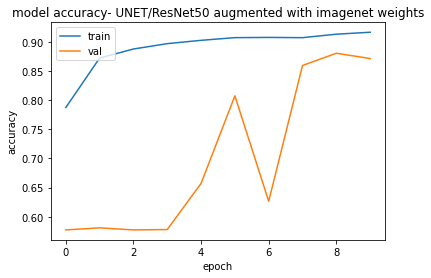

In [105]:
plt.plot(model_unet_resnet50_imagenet_history.history['accuracy'])
plt.plot(model_unet_resnet50_imagenet_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNet50 augmented with imagenet weights')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

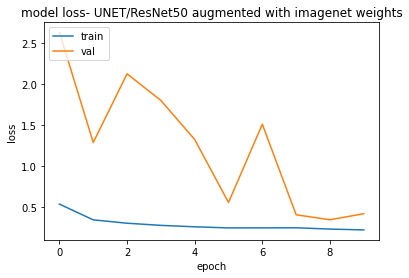

In [106]:
plt.plot(model_unet_resnet50_imagenet_history.history['loss'])
plt.plot(model_unet_resnet50_imagenet_history.history['val_loss'])
plt.title('model loss- UNET/ResNet50 augmented with imagenet weights')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50_imagenet_augmented.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.9043299523674787
test IoU:  0.8894561168198877
unseen IoU:  0.8948707451229336


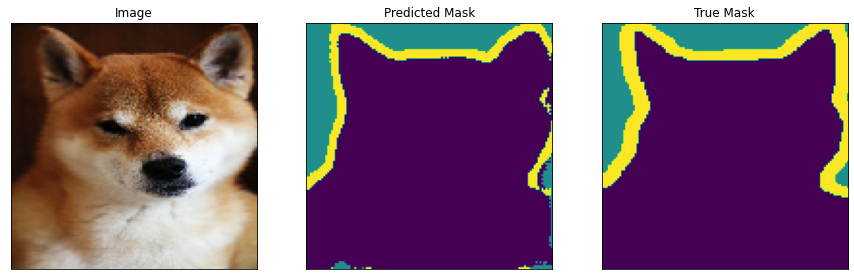

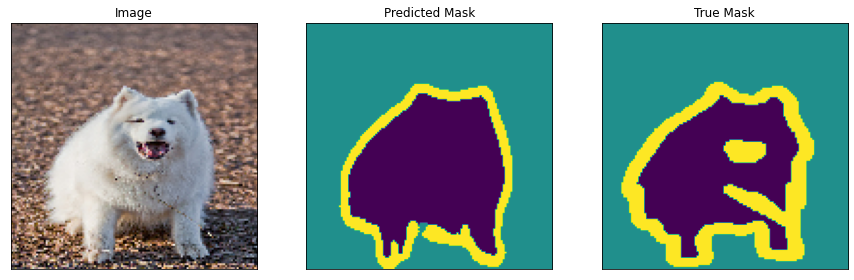

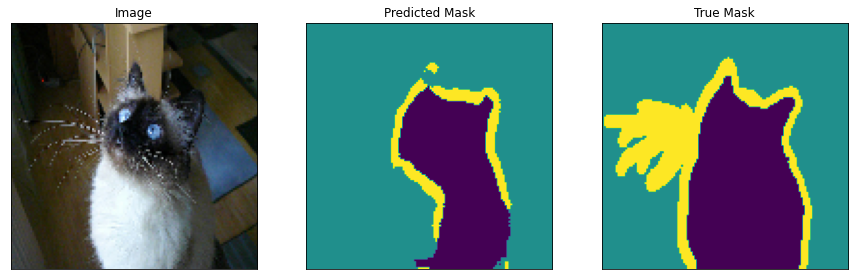

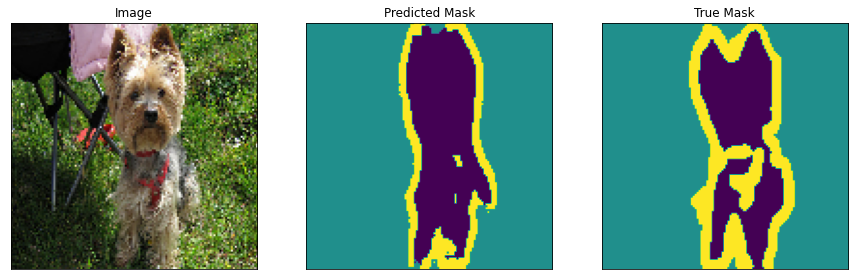

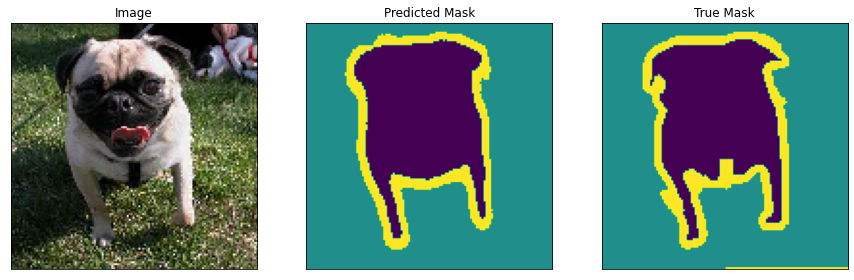

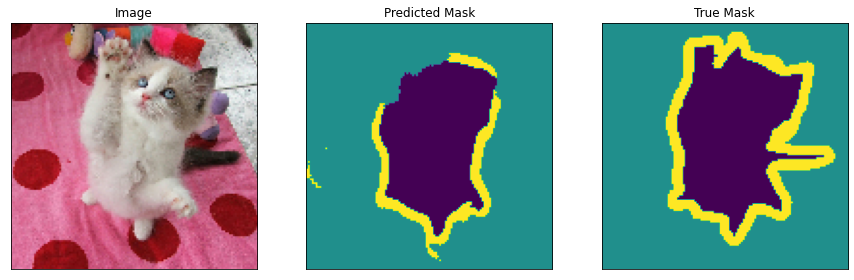

In [107]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50_imagenet_augmented.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

# ResNet50 with UNet decoder, NO augmented image and imagenet weights

In [23]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [24]:
train = dataset['train'].map(load_image_train)
unseen = dataset['unseen'].map(load_image_unseen)
test = dataset['test'].map(load_image_test)

BATCH_SIZE = 32

train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [110]:
# creating the model

OUTPUT_CHANNELS = 3

def ResNet50_Unet_imagenet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, 
                                   output_channels = OUTPUT_CHANNELS,
                                  model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet50_imagenet_noaugmentation = ResNet50_Unet_imagenet()
model_unet_resnet50_imagenet_noaugmentation.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [111]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3) # interrupts training when accuracy has stopped improving for more than 3 epoch
]   

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnet50_imagenet_noaugmentation.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnet50_imagenet_noaugmentation_history = model_unet_resnet50_imagenet_noaugmentation.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/10
115/115 [==============================] - 2078s 18s/step - loss: 0.5419 - accuracy: 0.7794 - val_loss: 2.3051 - val_accuracy: 0.5774
Epoch 2/10
115/115 [==============================] - 2136s 19s/step - loss: 0.3247 - accuracy: 0.8765 - val_loss: 2.1994 - val_accuracy: 0.5774
Epoch 3/10
115/115 [==============================] - 2115s 18s/step - loss: 0.2824 - accuracy: 0.8927 - val_loss: 1.8507 - val_accuracy: 0.5778
Epoch 4/10
115/115 [==============================] - 2181s 19s/step - loss: 0.2566 - accuracy: 0.9022 - val_loss: 2.2177 - val_accuracy: 0.5869
Epoch 5/10
115/115 [==============================] - 2159s 19s/step - loss: 0.2316 - accuracy: 0.9099 - val_loss: 1.4694 - val_accuracy: 0.6512
Epoch 6/10
115/115 [==============================] - 2167s 19s/step - loss: 0.2257 - accuracy: 0.9125 - val_loss: 0.7672 - val_accuracy: 0.7549
Epoch 7/10
115/115 [==============================] - 2131s 19s/step - loss: 0.2090 - accuracy: 0.9179 - val_loss: 0.4623 - val_ac

In [136]:
#model_unet_resnet50_imagenet_noaugmentation.save('unet_resnet50_imagenet_model.h5')
model_unet_resnet50_imagenet_noaugmentation = keras.models.load_model('unet_resnet50_imagenet_model.h5')

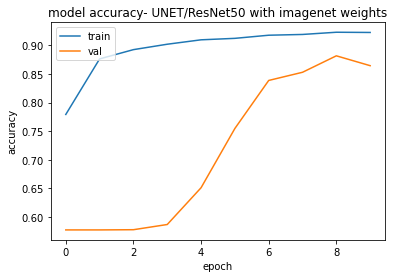

In [113]:
plt.plot(model_unet_resnet50_imagenet_noaugmentation_history.history['accuracy'])
plt.plot(model_unet_resnet50_imagenet_noaugmentation_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNet50 with imagenet weights')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

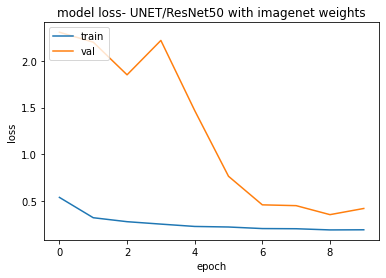

In [114]:
plt.plot(model_unet_resnet50_imagenet_noaugmentation_history.history['loss'])
plt.plot(model_unet_resnet50_imagenet_noaugmentation_history.history['val_loss'])
plt.title('model loss- UNET/ResNet50 with imagenet weights')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50_imagenet_noaugmentation.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.9137257209768346
test IoU:  0.8871462742480288
unseen IoU:  0.8907916685897393


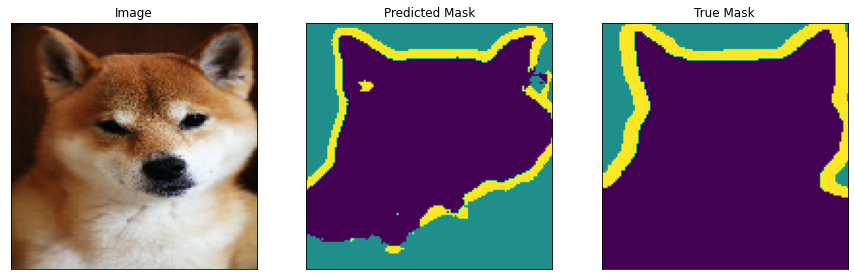

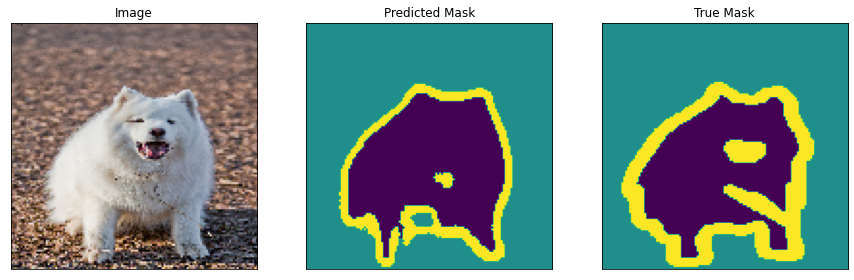

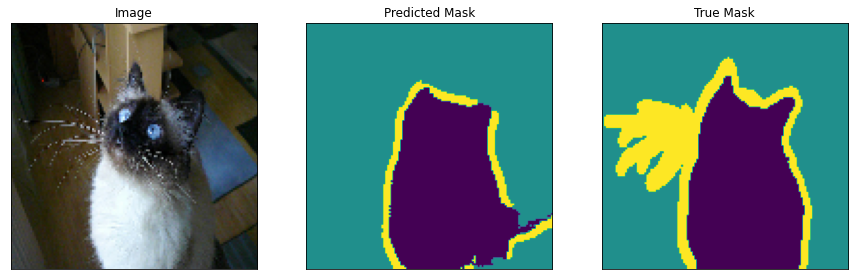

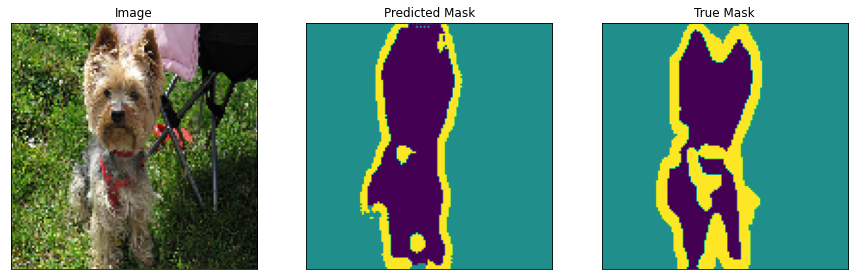

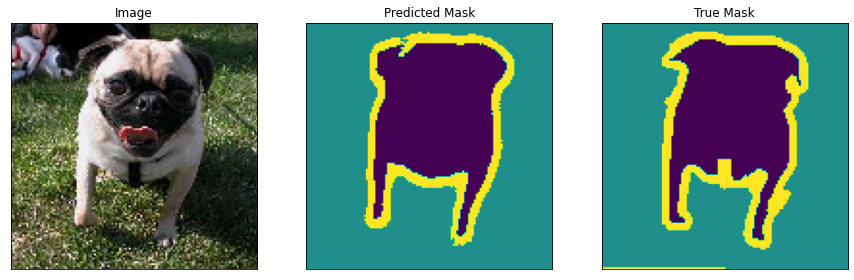

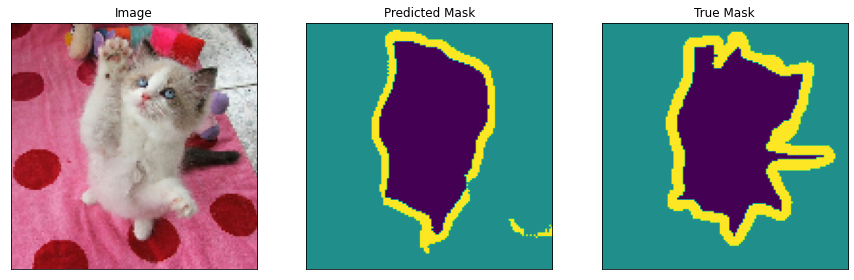

In [115]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet50_imagenet_noaugmentation.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


IndexError: index 3 is out of bounds for axis 3 with size 3

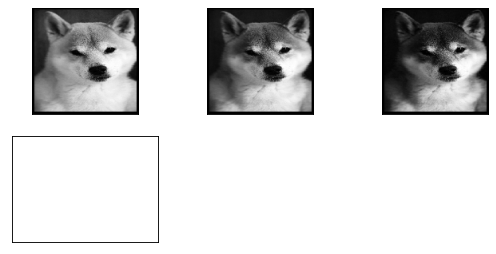

In [137]:
#feature_maps = model.predict(img)
#from keras.preprocessing.image import preprocess_input
from numpy import expand_dims

model = model_unet_resnet50_imagenet_noaugmentation
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

img = unseen_image[15]
img = expand_dims(img, axis=0)
#img = preprocess_input(img)

feature_maps = model.predict(img)

# plot all 64 maps in an 8x8 squares
square = 3
ix = 1

plt.figure(figsize=(8, 6), dpi=80)
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0,:, :,ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

# ResNet34 model

In [141]:
!pip install torchvision
import torchvision.models as tmodels

You should consider upgrading via the 'c:\users\jkuhn\anaconda_new\python.exe -m pip install --upgrade pip' command.


In [142]:
resnet_model = tmodels.resnet34(True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\jkuhn/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [143]:
resnet_model.summary()

AttributeError: 'ResNet' object has no attribute 'summary'

In [137]:
from keras.applications.resnet import ResNet34

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_block(input_tensor):
    x = input_tensor
    base_model = ResNet34(include_top = False, input_shape=(128, 128, 3), weights=None)
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# adding a decoder
def decoder_block(inputs,
                  conv_output, n_filters, kernel_size,
                  strides=1, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, 
                                        strides = strides, 
                                        padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def resnet_decoder_block(inputs, output_channels, model_name):
    conv_layers = []
    for layer in model_name.layers:
        name_layers = layer.name
        if name_layers.endswith('conv'):
            conv_layers.append(name_layers)  # get conv layer name from CNNs
            
    model_inputs = []
    for name in conv_layers:
        a = model_name.get_layer(name).output
        model_inputs.append(a)   # get conv layer info from CNNs
        
    model_names = []   # get the outputs of each CNN blocks
    for m in range(len(model_inputs)):
        if model_inputs[m-1].shape[1] == model_inputs[m].shape[1]:
            continue
        model_names.append(model_inputs[m-1])
    model_names = model_names[1:] + model_names[:1]
    model_names = model_names[::-1] # get the inverse for the reverse
    
    for conv in model_names[1:-1]: #[:-1]:
        inputs = decoder_block(inputs, conv, n_filters = conv.shape[3], 
                               kernel_size = (3,3), 
                              strides = (2,2),
                              dropout = 0.3)
        
    inputs = decoder_block(inputs, model_names[-1], 
                           n_filters = model_names[-1].shape[3],
                          kernel_size = (3,3), strides = (2,2), dropout=0.3)
    
    # transpose result back to (128, 128) image
    inputs = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3),
                                            strides = (2,2), 
                                            kernel_initializer = 'he_normal',
                                            padding = 'same')(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = (tf.keras.layers.Conv2D(3, (1,1), activation = 'softmax'))(inputs)
    return inputs

ImportError: cannot import name 'ResNet34' from 'keras.applications.resnet' (C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\applications\resnet.py)

In [ ]:
# creating the model

OUTPUT_CHANNELS = 3

def ResNeXT_Unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, 
                                   output_channels = OUTPUT_CHANNELS,
                                  model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnext = ResNeXT_Unet()
model_unet_resnext.summary()

In [ ]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3) # interrupts training when accuracy has stopped improving for more than 3 epoch
]   

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnext.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnext_history = model_unet_resnext.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

In [ ]:
model_unet_resnext.save('unet_resnext_model.h5')
model_unet_resnext = keras.models.load_model('unet_resnext_model.h5')

In [ ]:
plt.plot(model_unet_resnext_history.history['accuracy'])
plt.plot(model_unet_resnext_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNeXT')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_unet_resnext_history.history['loss'])
plt.plot(model_unet_resnext_history.history['val_loss'])
plt.title('model loss- UNET/ResNeXT')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnext.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

# ResNext model with imagenet weights

In [ ]:
def resnet_block(input_tensor):
    x = input_tensor
    base_model = ResNeXt50(include_top = False, input_shape=(128, 128, 3), weights='imagenet')
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

In [ ]:
# creating the model

OUTPUT_CHANNELS = 3

def ResNeXT_Unet_imagenet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3,))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, 
                                   output_channels = OUTPUT_CHANNELS,
                                  model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnext_imagenet = ResNeXT_Unet_imagenet()
model_unet_resnext_imagenet.summary()

In [ ]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3) # interrupts training when accuracy has stopped improving for more than 3 epoch
]   

EPOCHS = 10  # in the interest of time

# get model
model_unet_resnext_imagenet.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_unet_resnext_imagenet_history = model_unet_resnext_imagenet.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

In [ ]:
model_unet_resnext_imagenet.save('unet_resnext_imagenet_model.h5')
model_unet_resnext_imagenet = keras.models.load_model('unet_resnext_imagenet_model.h5')

In [ ]:
plt.plot(model_unet_resnext_imagenet_history.history['accuracy'])
plt.plot(model_unet_resnext_imagenet_history.history['val_accuracy'])
plt.title('model accuracy- UNET/ResNeXT imagenet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_unet_resnext_imagenet_history.history['loss'])
plt.plot(model_unet_resnext_imagenet_history.history['val_loss'])
plt.title('model loss- UNET/ResNeXT imagenet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnext_imagenet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

# ResNext model with augmented data

# ResNext model with augmented data, imagenet weights